In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Load cascade classifier models
face_cascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv.CascadeClassifier("haarcascade_eye.xml")

In [19]:
def detect_face(img: np.ndarray, face_class: cv.CascadeClassifier) -> np.ndarray:
    """Method to identify the face in an image.

    Args:
        img: the incoming image as a numpy n-d array.
        face_class: the pre-trained classifier for finding the face in an image.

    Returns:
        face_img: a copy of the input image with a rectable around the face. 
    """
    face_img = img.copy()
    face_rectangle = face_class.detectMultiScale(
        face_img,
        scaleFactor=1.1,
        minNeighbors=5
    )
    for (x, y, w, h) in face_rectangle:
        cv.rectangle(face_img, (x,y), (x + w, y + h), (255, 255, 255), 10)
    return face_img

def detect_eyes(img: np.ndarray, eye_class: cv.CascadeClassifier) -> np.ndarray:
    """Method to identify the eyes in an image
    
    Args:
        img: the incoming image as a numpy n-d array
        eye_class: the pre-trained classifier for finding the eyes in an image
    
    Returns:
        eye_image: a copy of the input image with a rectangle around the eyes
    """
    eye_img = img.copy()
    eye_rect = eye_class.detectMultiScale(
        eye_img,
        scaleFactor=1.1,
        minNeighbors=5
    )
    for (x, y, w, h) in eye_rect:
        cv.rectangle(eye_img, (x,y), (x + w, y + h), (255, 255, 255), 10)
    return eye_img

def calc_euclidean_distance(embedding_one, embedding_two):
    distance = np.linalg.norm(embedding_one - embedding_two)
    return distance

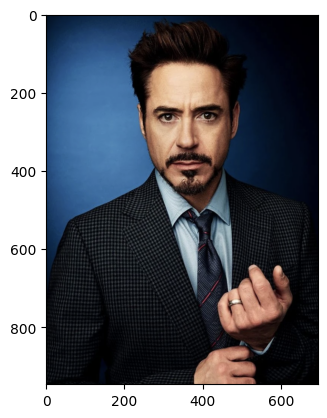

<Figure size 640x480 with 0 Axes>

In [7]:
# This section will be showing the face identification through a single image
base_rob = cv.imread("./train_images/robert_1.png")
plt.imshow(cv.cvtColor(base_rob, cv.COLOR_BGR2RGB))  # Load the figure in matplotlib
plt.show()  # Show the image directly
plt.clf()  # Clear the contents of the matplotlib figure

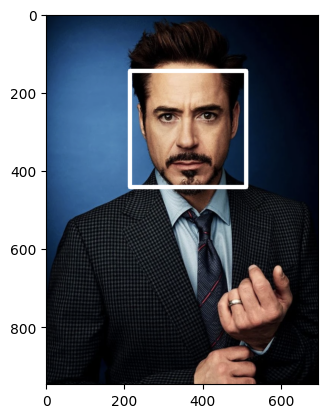

<Figure size 640x480 with 0 Axes>

In [8]:
cp_one = base_rob.copy()
face_rob_one = detect_face(cp_one, face_cascade)
plt.imshow(cv.cvtColor(face_rob_one, cv.COLOR_BGR2RGB))  
plt.show()
plt.clf()

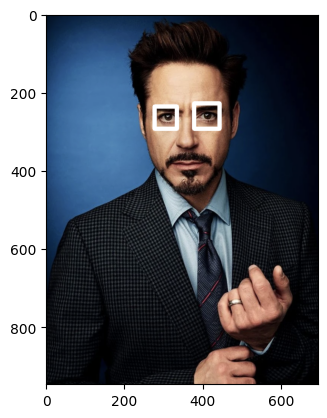

<Figure size 640x480 with 0 Axes>

In [11]:
cp_two = base_rob.copy()
eyes_rob_one = detect_eyes(cp_two, eye_cascade)
plt.imshow(cv.cvtColor(eyes_rob_one, cv.COLOR_BGR2RGB))
plt.show()
plt.clf()

In [23]:
""" Facial Recognition and classification """
# Get your training data
train_dir = Path.cwd() / "train_images"
train_faces = []
train_labels = []

for file in list(train_dir.rglob("*.png")):  # Iterate through all png files in /images
    img = cv.imread(file)
    train_faces.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    label_name = file.name.split("_")[0]
    train_labels.append(0) if label_name == "robert" else train_labels.append(1)

# Get your test data
test_dir = Path.cwd() / "test_images"
test_faces = []
test_labels = []
for file in list(test_dir.rglob("*.png")):
    img = cv.imread(file)
    test_faces.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    label_name = file.name.split("_")[0]
    test_labels.append(0) if label_name == "robert" else test_labels.append(1)

In [37]:
""" Facial Comparison using Face Embeddings """
# compare using euclidean distance
johnny = cv.imread("./test_images/johnny_test.png")
robert = cv.imread("./test_images/robert_test.png")
johnny_other = cv.imread("./train_images/johnny_2.png")
johnny2 = detect_face(johnny, face_cascade)
robert2 = detect_face(robert, face_cascade)
johnny_face = face_cascade.detectMultiScale(johnny2, scaleFactor=1.1, minNeighbors=5)
robert_face = face_cascade.detectMultiScale(robert2, scaleFactor=1.1, minNeighbors=5)
johnny_other_face = face_cascade.detectMultiScale(johnny_other, scaleFactor=1.1, minNeighbors=5)

fixed_sizes = []
target_width = 255
target_height = 255

# Need to adjust the size because the two images need to be same shape
# Getting size from center here
for (x, y, w, h) in johnny_face:
    center_x = x + w // 2
    center_y = y + h // 2
    new_x = target_width // 2
    new_y = target_height // 2
    fixed_sizes.append((new_x, new_y, target_width, target_height))
# Reshaping the images here to same shape
for (x, y, w, h) in fixed_sizes:
    cv.rectangle(johnny_face, (x, y), (x + w, y + h), (0, 255, 0), 10)
    cv.rectangle(robert_face, (x, y), (x + w, y + h), (0, 255, 0), 10)
    cv.rectangle(johnny_other_face, (x, y), (x + w, y + h), (0, 255, 0), 10)
    
# Calculate the Eulcidean Distance (Straight line between points)
euclidean_diff_face = calc_euclidean_distance(johnny_face, robert_face)
johnny_johnny_distance = calc_euclidean_distance(johnny_face, johnny_other_face)

print(f"The Euclidean Distance between Johnny Face Embedding and Robert Face Embedding is {euclidean_diff_face}")
print(f"The Euclidean Distance between Johnny Face Embedding and Johnny Other Face Emdedding is {johnny_johnny_distance}")

The Euclidean Distance between Johnny Face Embedding and Robert Face Embedding is 31.480152477394387
The Euclidean Distance between Johnny Face Embedding and Johnny Other Face Emdedding is 26.851443164195103


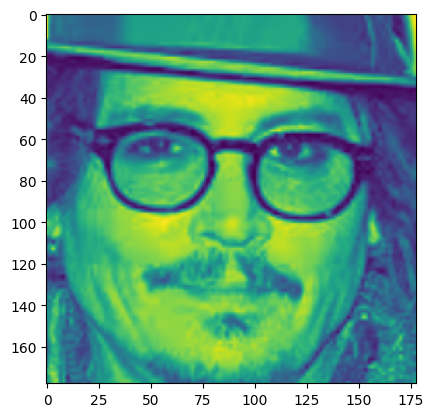

Predicted: 1
Actual label: 1
Confidence in prediction: 85.39631717979871



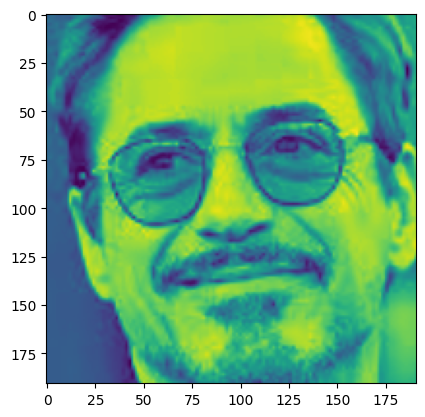

Predicted: 0
Actual label: 0
Confidence in prediction: 82.27095618257844



In [29]:
    # Train your recognizer
    facial_recognizer = cv.face.LBPHFaceRecognizer_create()
    facial_recognizer.train(train_faces, np.array(train_labels))

    # Testing prediction
    for image, act_label in zip(test_faces, test_labels):
        gray_face = detect_face(image, face_cascade)
        face = face_cascade.detectMultiScale(gray_face, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in face:
            roi_gray = image[y:y+h, x:x+w]
            plt.imshow(roi_gray)
            plt.show()
            pred_label, confidence = facial_recognizer.predict(roi_gray)
            print(f"Predicted: {pred_label}")
            print(f"Actual label: {act_label}")
            print(f"Confidence in prediction: {confidence}\n")